<a id="cuarto"></a>
## 4. Aplicación de una red neuronal en Localización
Desde la edad antigua, múltiples formas de localización han sido desarrolladas. Dentro de los avances más importantes en este ámbito, es el desarrollo de la teorı́a cientı́fica y técnica denominada georreferenciación. Gracias a GPS, el crecimiento y acceso de la georreferenciación y navegación está en progresivo aumento, el problema surge cuando se intentan estimar en recintos interiores (como edificios o bajo tierra) donde el GPS no funciona de la manera como uno esperaría, debido a que existen muchos obstáculos e interferencia que imposibilitan su uso.  
Dentro de interiores se cuenta con señales RSSI (*fingerprint*) que pueden atacar este problema, sin embargo los métodos actuales no son robustos a ruido, por lo que su tarea será la de abordar este problema para mejorar exactitud de sistemas de posicionamiento en interiores mediante redes neuronales.  

La metodología con la que se trabajará será que, para dentro de interiores, dispositivos *Bluetooth* emiten señales RSSI las cuales son captadas por el dispositivo "objetivo" al cual se le desea determinar su localización, recibiendo distintas intensidades de señal de cada dispositivo emisor debido a su posición en el interior. Los datos con los que se va a trabajar (*IndoorFingerprint.csv*) fueron provistos por el nuevo Ing. Civil Informático Felipe Berrios, éstos constan de 8 características (*C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI*) correspondientes a las mediciones hechas/recibidas por el dispositivo "objetivo" de las distintas señales RSSI emitidas por los dispositivos *Bluetooth* en los bordes del interior, además de tener la posición del dispositivo "objetivo" en un plano XY (valor a estimar).

<img src="https://i.imgur.com/Xheipaa.png" width="60%" height="20%" />

Grilla ejemplo de cómo funciona el sistema (elaboración por Felipe Berrios). Los 4 dispositivos en la esquina son los que emiten las señales RSSI, el punto naranja es el dispositivo que las recibe y es el "objetivo" a determinar la posición.

Una consideración importante es el cómo tratar la ausencia de la señal proveniente de un dispositivo *Bluetooth*, para estos datos se utiliza un valor de +100, ya que es imposible obtener este valor debido a las características de la escala RSSI (siempre negativa o igual a cero), pero puede ser sustituido por otro.  
Para hacer el trabajo mas simple se discretizará la posición en el plano definiendo zonas en dónde está el objeto a localizar. Las zonas deben ser las que indica la malla a continuación:

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18258789337625457952
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 176571186
locality {
  bus_id: 1
}
incarnation: 3877011529430302593
physical_device_desc: "device: 0, name: GeForce GTX 950, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

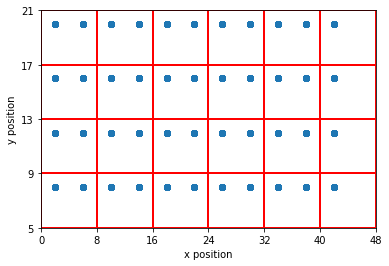

,X,Y,C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI
0,2.0,8.0,-66,-92,-84,-84,-92,-93,-98,-96
1,2.0,8.0,-66,-94,-84,-84,-94,-93,-98,-96
2,2.0,8.0,-66,-94,-84,-84,-94,-93,-98,-100
3,2.0,8.0,-66,-94,-84,-84,-94,-80,-98,-100
4,2.0,8.0,-66,-94,-84,-84,-94,-74,-98,-100


In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv("./IndoorFingerprint.csv")

import matplotlib.pyplot as plt
%matplotlib inline
X = df["X"]
Y = df["Y"]
plt.scatter(df["X"],df["Y"])

x_ticks = np.arange(0, 49, 8)
y_ticks = np.arange(5, 22, 4)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.grid(color='r', linestyle='-', linewidth=2)
plt.ylabel("y position")
plt.xlabel("x position")
plt.show()

conditions = [
    ((df['X'] > 0.0) & (df['X'] <= 8.0)) & ((df['Y'] > 0.0) & (df['Y'] <= 9.0)),
     ((df['X'] > 8) &  (df['X'] <= 16) ) & ((df['Y'] > 0) & (df['Y'] <= 9)),
     ((df['X'] > 16) & (df['X'] <= 24) ) & ((df['Y'] > 0) & (df['Y'] <= 9)),
     ((df['X'] > 24) & (df['X'] <= 32) ) & ((df['Y'] > 0) & (df['Y'] <= 9)),
     ((df['X'] > 32) & (df['X'] <= 40) ) & ((df['Y'] > 0) & (df['Y'] <= 9)),
     ((df['X'] > 40) & (df['X'] <= 48) ) & ((df['Y'] > 0) & (df['Y'] <= 9)),
     
     ((df['X'] > 0) & (df['X'] <= 8 )) &  ( (df['Y'] > 9 )& (df['Y'] <= 13)),
     ((df['X'] > 8) & (df['X'] <= 16 )) & ( (df['Y'] > 9 )& (df['Y'] <= 13)),
     ((df['X'] > 16) &( df['X'] <= 24) ) &( (df['Y'] > 9 )& (df['Y'] <= 13)),
     ((df['X'] > 24) &( df['X'] <= 32) ) &( (df['Y'] > 9 )& (df['Y'] <= 13)),
     ((df['X'] > 32) &( df['X'] <= 40) ) &( (df['Y'] > 9 )& (df['Y'] <= 13)),
     ((df['X'] > 40) &( df['X'] <= 48) ) &( (df['Y'] > 9 )& (df['Y'] <= 13)),
     
     ((df['X'] > 0 )& (df['X'] <= 8 )) &   ((df['Y'] > 13 )& (df['Y'] <= 17)),
     ((df['X'] > 8 )& (df['X'] <= 16 )) &  ((df['Y'] > 13 )& (df['Y'] <= 17)),
     ((df['X'] > 16) &( df['X'] <= 24) ) & ((df['Y'] > 13 )& (df['Y'] <= 17)),
     ((df['X'] > 24) &( df['X'] <= 32) ) & ((df['Y'] > 13 )& (df['Y'] <= 17)),
     ((df['X'] > 32) &( df['X'] <= 40) ) & ((df['Y'] > 13 )& (df['Y'] <= 17)),
     ((df['X'] > 40) &( df['X'] <= 48) ) & ((df['Y'] > 13 )& (df['Y'] <= 17)),
     
     ((df['X'] > 0 )&  (df['X'] <= 8 )) &  ((df['Y'] > 17) & (df['Y'] <= 21)),
     ((df['X'] > 8 )&  (df['X'] <= 16) ) & ((df['Y'] > 17) & (df['Y'] <= 21)),
     ((df['X'] > 16) & (df['X'] <= 24) ) & ((df['Y'] > 17) & (df['Y'] <= 21)),
     ((df['X'] > 24) & (df['X'] <= 32) ) & ((df['Y'] > 17) & (df['Y'] <= 21)),
     ((df['X'] > 32) & (df['X'] <= 40) ) & ((df['Y'] > 17) & (df['Y'] <= 21)),
     ((df['X'] > 40) & (df['X'] <= 48) ) & ((df['Y'] > 17) & (df['Y'] <= 21))]
     
choices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]


def  plot_confusion_matrixplot_co (cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

df.head()

Donde los puntos azules son los distintos datos superpuestos de las posiciones del objeto a localizar. Por ejemplo el punto (2,8) está en la primera zona (o en la primera zona del eje *x* y del eje *y*), el punto (2,20) está en la zona 19 (o en la primera zona del eje *x* y la cuarta zona del eje *y*). Esta discretización transforma el problema que en un principio podría ser de regresión para determinar la posición exacta, en un problema de clasificación dividiendo (dentro de los posibles valores) 6 zonas para el eje "*x*" y 4 zonas para el eje "*y*", contando con un total de 24 clases (24 zonas en la malla).

> Deberá entrenar una red neuronal *feed forward* para la clasificación de las 24 posibles clases, con el objetivo de tener un desempeño (*accuracy*) mayor al 75%.
#### Importante
El conjunto de pruebas está **fijado** a través de los indices de posiciones del dataset, por lo que deberá leer estos indices y crear el conjunto de pruebas a partir de éstos.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

mask_test = np.loadtxt('mask_test.csv',dtype="i")
df = pd.read_csv("./IndoorFingerprint.csv")

df['new_class'] = np.select(conditions, choices)
df = df.drop(['X','Y'], axis=1)

df_test = pd.DataFrame(df,index=mask_test)
df_train = pd.DataFrame(df.drop(df.index[mask_test]))
 
y_train = (pd.DataFrame(df_train['new_class']))
X_train = df_train.drop(['new_class'], axis=1)

y_test = (pd.DataFrame(df_test['new_class']))
X_test = df_test.drop(['new_class'], axis=1)

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)

scaler = StandardScaler().fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

y_train = pd.get_dummies(y_train,columns=["new_class"])
y_test = pd.get_dummies(y_test,columns=["new_class"])

X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.25)

print(X_test_scaled.shape,y_test.shape)
print(X_train_scaled.shape,y_train.shape)

(1980, 8) (1980, 24)
(4620, 8) (3465, 24)


>para esta sección, se generaron los conjuntos de entrenamiento, validación y prueba. Para todos los conjuntos, para los parametros de entradas X, se normalizaron los datos para trabajar todo en la misma escala y para la variable objetivo Y se transformaron las 24 clases enumeradas de 1 a 24 en "one hot vector" para representar una matriz de clases y que la cantidad de clases correspondiera a la cantidad de neuronas de salida.

>Para el caso de la división del training set, se tomo un 0.25% del trainig set original y se transformo en validation set para realizar pruebas en el modelo y ajustar los hyper parametros.

>Posteriormente se realizo el entrenamiento de la red con los parametros ajustados con el conjunto de validación:

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt
from keras.layers import Dropout

model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, kernel_initializer='uniform',activation='relu'))
model.add(Dense(24, kernel_initializer='uniform',activation = "softmax"))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=300,verbose=2, validation_data=(X_val, y_val))

Train on 3465 samples, validate on 1155 samples
Epoch 1/300
 - 1s - loss: 2.6052 - acc: 0.2690 - val_loss: 1.7258 - val_acc: 0.4078
Epoch 2/300
 - 0s - loss: 1.3757 - acc: 0.5330 - val_loss: 1.1675 - val_acc: 0.5931
Epoch 3/300
 - 1s - loss: 1.0364 - acc: 0.6511 - val_loss: 0.9247 - val_acc: 0.7082
Epoch 4/300
 - 1s - loss: 0.8731 - acc: 0.7076 - val_loss: 0.8195 - val_acc: 0.7368
Epoch 5/300
 - 1s - loss: 0.7815 - acc: 0.7397 - val_loss: 0.7359 - val_acc: 0.7541
Epoch 6/300
 - 0s - loss: 0.7308 - acc: 0.7541 - val_loss: 0.6599 - val_acc: 0.7896
Epoch 7/300
 - 1s - loss: 0.6812 - acc: 0.7726 - val_loss: 0.6214 - val_acc: 0.8017
Epoch 8/300
 - 1s - loss: 0.6404 - acc: 0.7847 - val_loss: 0.5954 - val_acc: 0.8130
Epoch 9/300
 - 1s - loss: 0.6038 - acc: 0.8006 - val_loss: 0.5556 - val_acc: 0.8277
Epoch 10/300
 - 1s - loss: 0.5730 - acc: 0.8066 - val_loss: 0.5107 - val_acc: 0.8511
Epoch 11/300
 - 1s - loss: 0.5532 - acc: 0.8173 - val_loss: 0.5143 - val_acc: 0.8519
Epoch 12/300
 - 1s - loss:

Epoch 97/300
 - 1s - loss: 0.1468 - acc: 0.9515 - val_loss: 0.1523 - val_acc: 0.9576
Epoch 98/300
 - 1s - loss: 0.1408 - acc: 0.9558 - val_loss: 0.1429 - val_acc: 0.9636
Epoch 99/300
 - 0s - loss: 0.1341 - acc: 0.9599 - val_loss: 0.1675 - val_acc: 0.9506
Epoch 100/300
 - 1s - loss: 0.1445 - acc: 0.9532 - val_loss: 0.1410 - val_acc: 0.9645
Epoch 101/300
 - 0s - loss: 0.1360 - acc: 0.9584 - val_loss: 0.1457 - val_acc: 0.9619
Epoch 102/300
 - 0s - loss: 0.1470 - acc: 0.9556 - val_loss: 0.1675 - val_acc: 0.9550
Epoch 103/300
 - 0s - loss: 0.1298 - acc: 0.9616 - val_loss: 0.1463 - val_acc: 0.9636
Epoch 104/300
 - 1s - loss: 0.1381 - acc: 0.9553 - val_loss: 0.1495 - val_acc: 0.9628
Epoch 105/300
 - 1s - loss: 0.1335 - acc: 0.9570 - val_loss: 0.1493 - val_acc: 0.9636
Epoch 106/300
 - 1s - loss: 0.1331 - acc: 0.9582 - val_loss: 0.1398 - val_acc: 0.9636
Epoch 107/300
 - 1s - loss: 0.1331 - acc: 0.9593 - val_loss: 0.1427 - val_acc: 0.9602
Epoch 108/300
 - 1s - loss: 0.1295 - acc: 0.9584 - val_lo

Epoch 193/300
 - 1s - loss: 0.0947 - acc: 0.9717 - val_loss: 0.1206 - val_acc: 0.9740
Epoch 194/300
 - 0s - loss: 0.0875 - acc: 0.9737 - val_loss: 0.1187 - val_acc: 0.9732
Epoch 195/300
 - 0s - loss: 0.0788 - acc: 0.9786 - val_loss: 0.1239 - val_acc: 0.9714
Epoch 196/300
 - 1s - loss: 0.0829 - acc: 0.9786 - val_loss: 0.1210 - val_acc: 0.9714
Epoch 197/300
 - 1s - loss: 0.0866 - acc: 0.9746 - val_loss: 0.1345 - val_acc: 0.9671
Epoch 198/300
 - 1s - loss: 0.0821 - acc: 0.9752 - val_loss: 0.1188 - val_acc: 0.9740
Epoch 199/300
 - 0s - loss: 0.0922 - acc: 0.9760 - val_loss: 0.1158 - val_acc: 0.9706
Epoch 200/300
 - 1s - loss: 0.0792 - acc: 0.9769 - val_loss: 0.1281 - val_acc: 0.9636
Epoch 201/300
 - 1s - loss: 0.0812 - acc: 0.9766 - val_loss: 0.1191 - val_acc: 0.9706
Epoch 202/300
 - 0s - loss: 0.0855 - acc: 0.9740 - val_loss: 0.1234 - val_acc: 0.9732
Epoch 203/300
 - 0s - loss: 0.0743 - acc: 0.9786 - val_loss: 0.1283 - val_acc: 0.9706
Epoch 204/300
 - 0s - loss: 0.0819 - acc: 0.9726 - val

Epoch 289/300
 - 1s - loss: 0.0612 - acc: 0.9856 - val_loss: 0.1204 - val_acc: 0.9749
Epoch 290/300
 - 1s - loss: 0.0610 - acc: 0.9821 - val_loss: 0.1166 - val_acc: 0.9775
Epoch 291/300
 - 1s - loss: 0.0633 - acc: 0.9827 - val_loss: 0.1125 - val_acc: 0.9732
Epoch 292/300
 - 1s - loss: 0.0642 - acc: 0.9824 - val_loss: 0.1090 - val_acc: 0.9784
Epoch 293/300
 - 1s - loss: 0.0606 - acc: 0.9847 - val_loss: 0.1174 - val_acc: 0.9740
Epoch 294/300
 - 1s - loss: 0.0711 - acc: 0.9795 - val_loss: 0.1223 - val_acc: 0.9732
Epoch 295/300
 - 1s - loss: 0.0647 - acc: 0.9830 - val_loss: 0.1212 - val_acc: 0.9758
Epoch 296/300
 - 1s - loss: 0.0543 - acc: 0.9864 - val_loss: 0.1193 - val_acc: 0.9758
Epoch 297/300
 - 1s - loss: 0.0606 - acc: 0.9844 - val_loss: 0.1400 - val_acc: 0.9645
Epoch 298/300
 - 1s - loss: 0.0594 - acc: 0.9859 - val_loss: 0.1150 - val_acc: 0.9766
Epoch 299/300
 - 1s - loss: 0.0644 - acc: 0.9812 - val_loss: 0.1246 - val_acc: 0.9740
Epoch 300/300
 - 1s - loss: 0.0647 - acc: 0.9821 - val

> Como podemos ver, al final del entrenamiento de la red, el validation loss llego a un valor mínimo de 0.134, y el accuracy esta rodeado el 98% tanto en entrenamiento como en validación, para visualizar mejor este echo, plotearemos como cambian estos valores por cada epoach, los plot deberían ir decreciendo exponencialmente hasta llegar a los valores anteriormente mencionados.

Text(0.5,1,'Loss Curves')

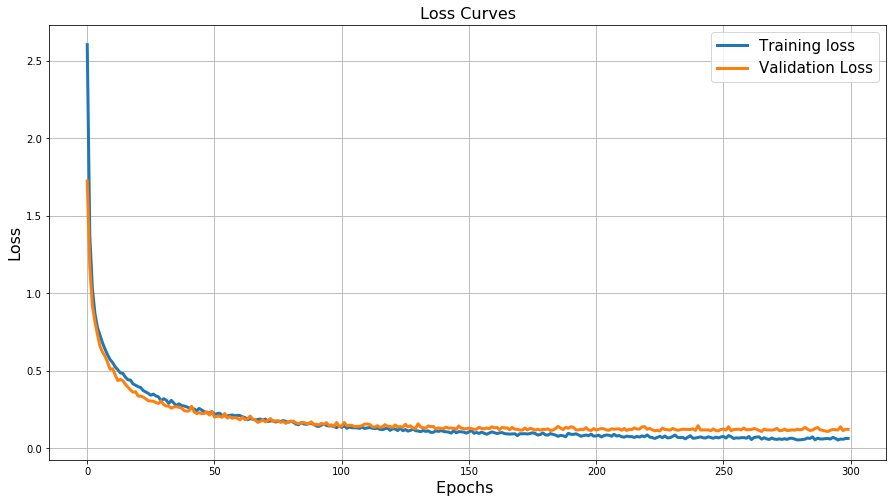

In [19]:
plt.figure(figsize=[15,8])
plt.grid()
plt.plot(hist.history['loss'],linewidth=3.0)
plt.plot(hist.history['val_loss'],linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=15)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

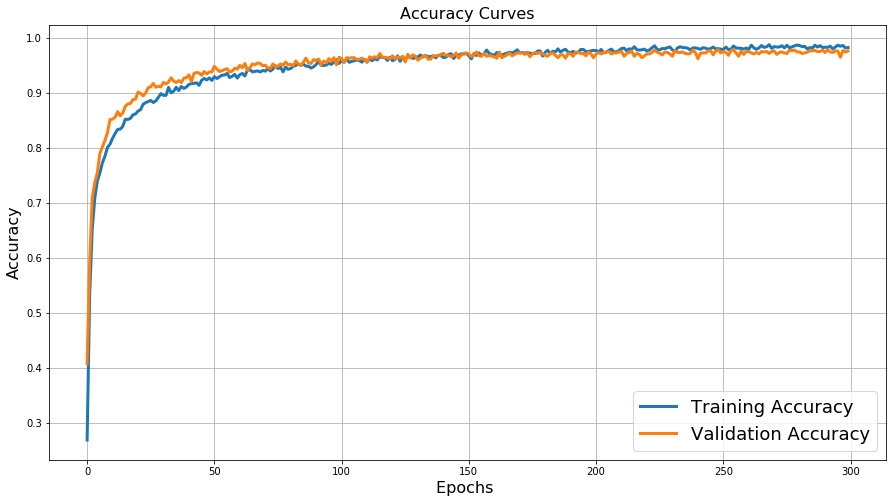

In [20]:
plt.figure(figsize=[15,8])
plt.grid()
plt.plot(hist.history['acc'],linewidth=3.0)
plt.plot(hist.history['val_acc'],linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

> Como se puede notar, las gráficas del accuracy y loss function del modelo se comportan de acuerdo a lo esperado, con la clara tendencia a un pequeño sobre ajuste ya que la linea de validación se separa un poco sobre la linea de entrenamiento, por lo cual el resultado al probar el modelo con el conjunto de prueba no debería cambiar mas o menos de entre el 90% al 97% de accuracy

In [21]:
scores = model.evaluate(X_test_scaled, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 95.96%


> Efectivamente el accuracy de nuestra red con el conjunto de prueba es del 96.11%, lo cual es un nivel bastante bueno para la simplicidad de la red, por ultimo, graficamos una matriz de confusión para ver cuales son las clases peor clasificadas:

Normalized confusion matrix
Confusion matrix, without normalization


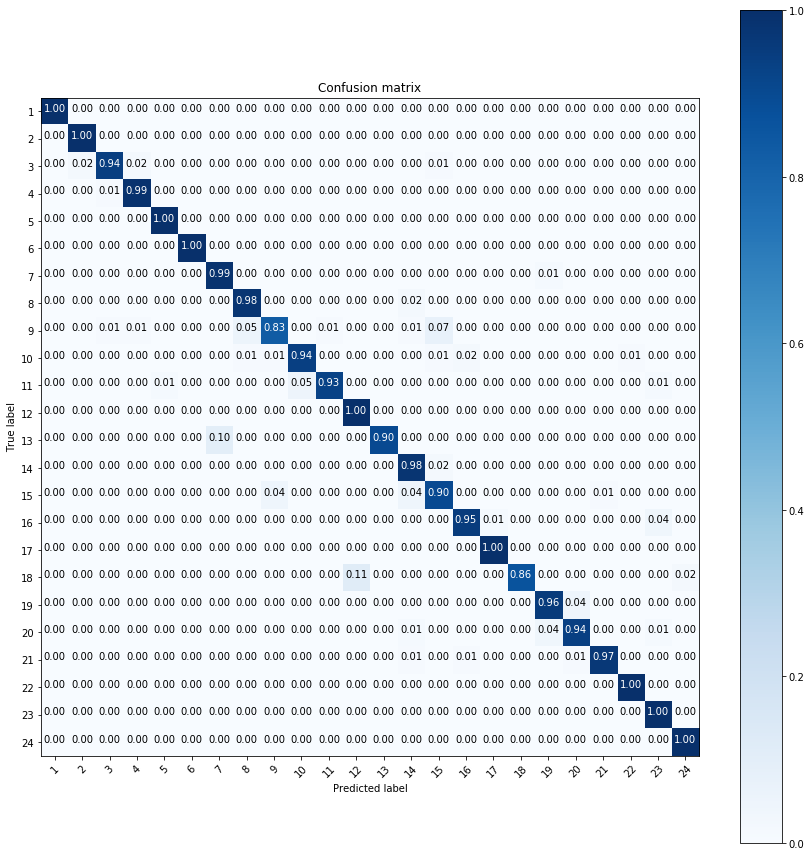

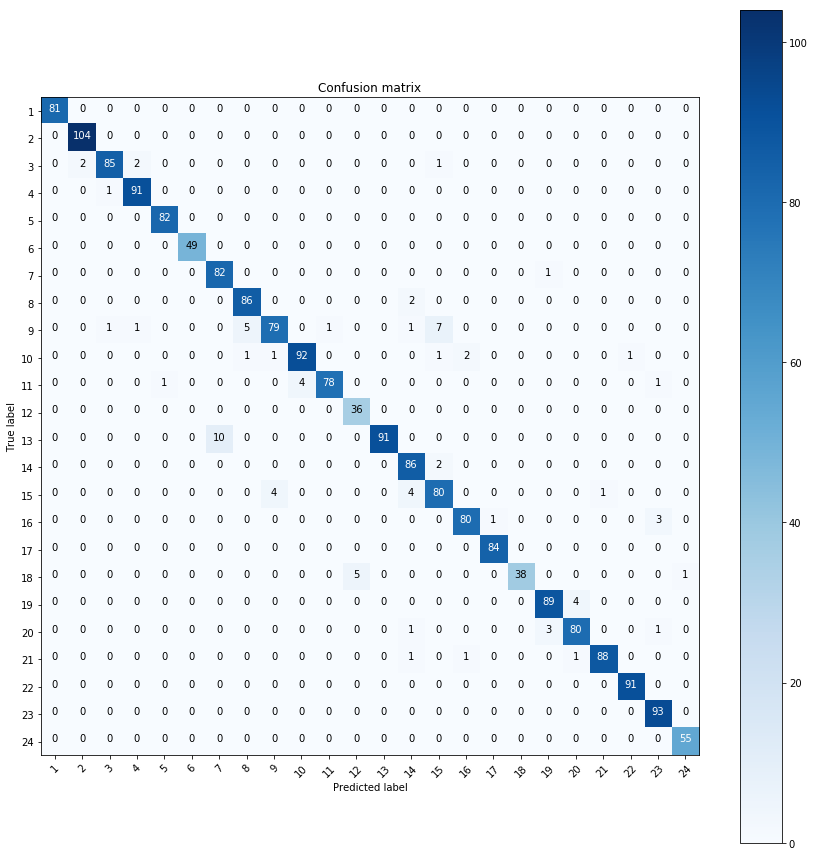

In [22]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
y_pred = model.predict(X_test_scaled)
cnf_matrix  =  confusion_matrix([np.argmax(x) for x in np.asarray(y_test)], [np.argmax(x) for x in y_pred])
plot_confusion_matrix(cnf_matrix, choices,normalize=True)
plot_confusion_matrix(cnf_matrix, choices)

> Como podemos ver, casi todas las clases se clasifican correctamente, y las únicas clases con un accuracy menor al 90% es la clase 9 y 18, pero esto puede cambiar cada vez que se entrene la red (ya que las redes no son deterministas) y lo normal es que 2 clases queden bajo el 90% de accuracy.